#  BinWaves North Carolina Satellite Correction - NC-SC (Reconstruction)

### BinWaves Notebooks Overview

This Jupyter Notebook is the first of three in the **BinWaves** modeling workflow, following Cagigal et al., 2024 :

1. `BinWaves_Propagation.ipynb`  
2. `BinWaves_Reconstruction.ipynb`  
3. `BinWaves_Validation.ipynb`

---

#### Before You Start

Make sure you have:

- Installed the latest version of `bluemath-tk`:  
  ```bash
  pip install bluemath-tk

Before continuing, ensure you have **created and activated a Python environment**.

*** Other Required Packages ***
- `wavespectra` 
- `cartophy`
 
---

<details>
<summary><strong>📁 BinWaves_Propagation.ipynb</strong></summary>

This notebook constructs the **library of pre-run cases** for all **monochromatic wave systems**.

##### Requirements:

- A **bathymetry** file placed in the `outputs/` folder, in the correct format.

If you don't have a specific bathymetry file for your study area, you can:

- **Download GEBCO bathymetry data** (~400 m resolution):  [https://download.gebco.net/](https://download.gebco.net/)


</details>

---

<details open>
<summary><strong>📁 BinWaves_Reconstruction.ipynb</strong></summary>

This notebook reconstructs **wave conditions** using **offshore directional wave spectra**.

##### Requirements:

- Offshore wave spectrum data (e.g., **CAWCR** or **ERA5** datasets).
  - CAWCR spectra can be downloaded using a helper script (e.g., Javi's code?).

- **NOTE**: Optionally, apply **satellite corrections** to the hindcast spectrum before running BinWaves using the `CalVal` notebook, which handles the required format conversions.

</details>

---

<details>
<summary><strong>📁 BinWaves_Validation.ipynb</strong></summary>

This notebook performs **validation** using **wave buoy data**, if available.

##### Requirements:

- Wave buoy data in a format compatible with BinWaves (if available).
- Some wave buoy data can be freely downloaded from:  
  🌊 [https://www.ndbc.noaa.gov/](https://www.ndbc.noaa.gov/)

- **NOTE:** You can use the `NDBC_buoy_data.ipynb` notebook to:
  - Download the buoy data.
  - Convert it into the appropriate format for BinWaves.

</details>

In [2]:
import xarray as xr

# Load all the gridded kps and reproject
kp_coeffs = xr.open_dataset("outputs/kp_coefficients.nc")
kp_coeffs

<xarray.Dataset> Size: 2GB
Dimensions:   (case_num: 696, site: 536, freq: 31, dir: 24)
Coordinates:
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * site      (site) int64 4kB 1 2 3 4 5 6 7 8 ... 530 531 532 533 534 535 536
  * freq      (freq) float64 248B 0.03 0.0329 0.0362 ... 0.4145 0.4552 0.5
  * dir       (dir) float64 192B 2.5 17.5 32.5 47.5 ... 302.5 317.5 332.5 347.5
    lat       float64 8B ...
    lon       float64 8B ...
    utm_x     (site) float64 4kB ...
    utm_y     (site) float64 4kB ...
Data variables:
    kps       (case_num, site, freq, dir) float64 2GB ...

## Offshore Spectrum

> ⚠️ **NOTE:** If satellite correction was applied, ensure that 'satellite_correction=True'. The default value is False.

In [6]:
import pandas as pd
from utils.operations import transform_ERA5_spectrum

model_parameters = pd.read_csv("NC_SC/swan_cases.csv").to_dict(orient="list")

# Load interest spectra

offshore_spectra, offshore_spectra_case = transform_ERA5_spectrum(
    era5_spectrum=xr.open_dataset("inputs/satellite_corrected_44088_spectrum_cal.nc"),
    subset_parameters=model_parameters,
    available_case_num=kp_coeffs.case_num.values,
    satellite_correction=True,
)
offshore_spectra_case

<xarray.DataArray 'efth' (case_num: 696, time: 405963)> Size: 2GB
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.71341895e-19],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * case_num  (case_num) int64 6kB 0 1 2 3 4 5 6 ... 689 690 691 692 693 694 695
  * time      (time) datetime64[ns] 3MB 1979-01-01 ... 2025-04-01
    station   int32 4B 133

In [7]:
from bluemath_tk.waves.binwaves import reconstruc_spectra

time_to_reconstruct = "2022-02-20"

# Reconstruct spectra
reconstructed_onshore_spectra = reconstruc_spectra(
    offshore_spectra=offshore_spectra_case.sel(time=time_to_reconstruct),
    kp_coeffs=kp_coeffs,
    num_workers=8,
)
reconstructed_onshore_spectra

/home/tausiaj/miniforge3/envs/bluemath-dev/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35387 instead
  warnings.warn(


<xarray.Dataset> Size: 77MB
Dimensions:  (site: 536, freq: 31, dir: 24, time: 24)
Coordinates:
  * site     (site) int64 4kB 1 2 3 4 5 6 7 8 ... 530 531 532 533 534 535 536
  * freq     (freq) float64 248B 0.03 0.0329 0.0362 0.0397 ... 0.4145 0.4552 0.5
  * dir      (dir) float64 192B 2.5 17.5 32.5 47.5 ... 302.5 317.5 332.5 347.5
    lat      float64 8B 0.0
    lon      float64 8B 0.0
    utm_x    (site) float64 4kB -77.2 -77.12 -77.03 ... -77.72 -77.76 -78.02
    utm_y    (site) float64 4kB 32.8 32.9 33.0 33.1 ... 34.21 34.14 33.44 33.72
  * time     (time) datetime64[ns] 192B 2022-02-20 ... 2022-02-20T23:00:00.00...
    station  int32 4B 133
Data variables:
    kps      (time, site, freq, dir) float64 77MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

(<Figure size 1500x600 with 2 Axes>,
 <GeoAxes: xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

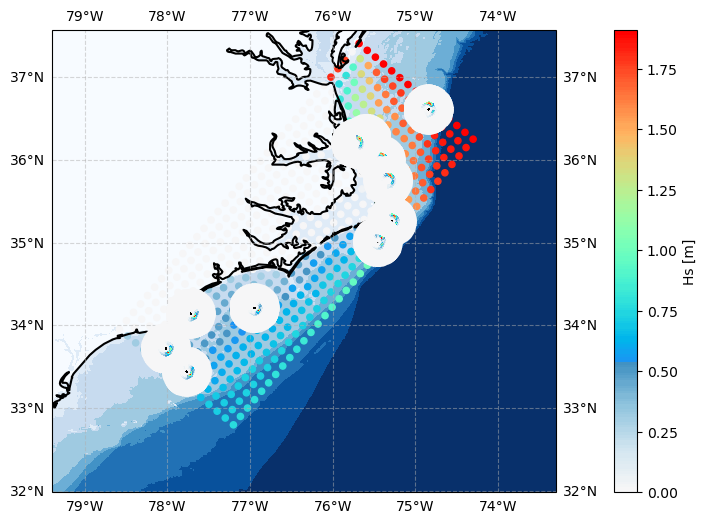

In [8]:
import xarray as xr
from utils.plotting import plot_spectrum_in_coastline

time_to_plot = "2022-02-20 12:00"

# Plot the spectrum along the coastline
bathy = xr.open_dataset("outputs/cropped_bathy_North_Carolina.nc").elevation.T
plot_spectrum_in_coastline(
    bathy=-bathy,
    reconstructed_onshore_spectra=reconstructed_onshore_spectra.rename({"kps": "kp"}),
    reconstruction_kps=kp_coeffs,
    offshore_spectra=offshore_spectra,
    time_to_plot=time_to_plot,
    sites_for_spectrum=list(range(-11, 0))

)